In [26]:
import torch
import torch.nn as nn
import math
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.functional import relu
import matplotlib.pyplot as plt
%matplotlib inline
data_dir='GW_data_max1e-21_noise5e-22/'
#device=torch.device('cuda:0')

pi=3.1415926
G=6.673e-11
c=299792458.0

Mpc=3.08567758e22
Msun = 1.989e30

In [2]:
def get_params(batch_size,step):
    
    
    params_dir='injection_bns_%s.txt'%(step*batch_size+1)
    params=np.loadtxt(data_dir+params_dir)
    params=params.reshape(1,9)
    
    i=1
    while i<batch_size:
        params_dir_append='injection_bns_%s.txt'%(step*batch_size+i+1)
        params_append=np.loadtxt(data_dir+params_dir_append)
        params_append=params_append.reshape(1,9)
        params=np.concatenate((params,params_append),axis=0)
        i=i+1
        
    return params

In [28]:
def zoom_func(params,start_t,end_t,wave_length,noise_factor):
    det_num=3
    noise_scale=5.0e-22
    #params=Variable(torch.from_numpy(params).cuda())
    #params=torch.tensor([params],requires_grad=True,dtype=torch.double).to(device)
    inj_time=torch.tensor(params[0],dtype=torch.double)
    Mc=torch.tensor(params[1]*Msun,dtype=torch.double)
    sphi=params[3]
    stheta=params[4]
    spsi=params[5]
    dl0=torch.tensor(params[6],dtype=torch.double)
    cosi=torch.tensor(params[7],dtype=torch.double)


    T1=end_t[0]-start_t[0]
    T2=end_t[1]-start_t[1]
    T3=end_t[2]-start_t[2]
    fs1=wave_length/T1
    fs2=wave_length/T2
    fs3=wave_length/T3
    nsamples=wave_length
    t1=start_t[0]+np.arange(nsamples)/fs1
    t2=start_t[1]+np.arange(nsamples)/fs2
    t3=start_t[2]+np.arange(nsamples)/fs3

    Det1_V=np.array([-2.161414928e+06,-3.834695183e+06,4.600350224e+06])
    Det2_V=np.array([-7.427604192e+04,-5.496283721e+06,3.224257016e+06])
    Det3_V=np.array([4546374.0,842990.0,4378577.0])
    Det1_d=np.array([[-0.392614701790361,-0.077612252813702,-0.247388405118613],
                     [-0.077612252813702,0.319524089053145,0.227998293910978],
                     [-0.247388405118613,0.227998293910978,0.073090613199948]])
    Det2_d=np.array([[0.411281743683125,0.140209630402064,0.247293475274344],
                     [0.140209630402064,-0.109005942619247,-0.181616030843724],
                     [0.247293475274344,-0.181616030843724,-0.302275800865383]])
    Det3_d=np.array([[0.243874678248284,-0.099086615422263,-0.232575796255783],
                     [-0.099086615422263,-0.447827871578090,0.187828534783639],
                     [-0.232575796255783,0.187828534783639,0.203953193329806]])
    
    
    
    dl=dl0*Mpc

    m1=math.sin(sphi)*math.cos(spsi)-math.cos(sphi)*math.cos(stheta)*math.sin(spsi)
    m2=-math.cos(sphi)*math.cos(spsi)-math.sin(sphi)*math.cos(stheta)*math.sin(spsi)
    m3=math.sin(stheta)*math.sin(spsi)
    n1=-math.sin(sphi)*math.sin(spsi)-math.cos(sphi)*math.cos(stheta)*math.cos(spsi)
    n2=math.cos(sphi)*math.sin(spsi)-math.sin(sphi)*math.cos(stheta)*math.cos(spsi)
    n3 =math.sin(stheta)*math.cos(spsi)
    mm=torch.tensor([m1*m1,m1*m2,m1*m3,m2*m1,m2*m2,m2*m3,m3*m1,m3*m2,m3*m3],dtype=torch.double)
    mn=torch.tensor([m1*n1,m1*n2,m1*n3,m2*n1,m2*n2,m2*n3,m3*n1,m3*n2,m3*n3],dtype=torch.double)
    nm=torch.tensor([n1*m1,n1*m2,n1*m3,n2*m1,n2*m2,n2*m3,n3*m1,n3*m2,n3*m3],dtype=torch.double)
    nn=torch.tensor([n1*n1,n1*n2,n1*n3,n2*n1,n2*n2,n2*n3,n3*n1,n3*n2,n3*n3],dtype=torch.double)
    e_plus=mm-nn
    e_cross=mn+nm
    #d1=torch.from_numpy(Det1_d.reshape(9)).cuda()
    #d2=torch.from_numpy(Det2_d.reshape(9)).cuda()
    #d3=torch.from_numpy(Det3_d.reshape(9)).cuda()
    d1=torch.tensor(Det1_d.reshape(9),dtype=torch.double)
    d2=torch.tensor(Det2_d.reshape(9),dtype=torch.double)
    d3=torch.tensor(Det3_d.reshape(9),dtype=torch.double)
    #Fp1=torch.sum(e_plus*Variable(d1))
    #Fx1=torch.sum(e_cross*Variable(d1))
    #Fp2=torch.sum(e_plus*Variable(d2))
    #Fx2=torch.sum(e_cross*Variable(d2))
    #Fp3=torch.sum(e_plus*Variable(d3))
    #Fp3=torch.sum(e_cross*Variable(d3))
    Fp1=torch.sum(e_plus*d1)
    Fx1=torch.sum(e_cross*d1)
    Fp2=torch.sum(e_plus*d2)
    Fx2=torch.sum(e_cross*d2)
    Fp3=torch.sum(e_plus*d3)
    Fx3=torch.sum(e_cross*d3)
    
    omega = torch.tensor([math.sin(stheta)*math.cos(sphi),math.sin(stheta)*math.sin(sphi),math.cos(stheta)],
                         dtype=torch.double)

    #delay_1=-torch.sum(Variable(torch.from_numpy(Det1_V).cuda())*omega)/c
    #delay_2=-torch.sum(Variable(torch.from_numpy(Det2_V).cuda())*omega)/c
    #delay_3=-torch.sum(Variable(torch.from_numpy(Det3_V).cuda())*omega)/c
    delay_1=-torch.sum(torch.from_numpy(Det1_V)*omega)/c
    delay_2=-torch.sum(torch.from_numpy(Det2_V)*omega)/c
    delay_3=-torch.sum(torch.from_numpy(Det3_V)*omega)/c
    tc1=inj_time+delay_1
    tc2=inj_time+delay_2
    tc3=inj_time+delay_3
    idinjt1=torch.ceil((tc1-start_t[0])*fs1)
    idinjt2=torch.ceil((tc2-start_t[1])*fs2)
    idinjt3=torch.ceil((tc3-start_t[2])*fs3)
    
    tau1=tc1-torch.from_numpy(t1)
    tau2=tc2-torch.from_numpy(t2)
    tau3=tc3-torch.from_numpy(t3)
    
    tau1_l=torch.from_numpy(end_t[0]-t1)
    tau2_l=torch.from_numpy(end_t[1]-t2)
    tau3_l=torch.from_numpy(end_t[2]-t3)
    
    
    tau1_phi=torch.pow(relu(tau1),5.0/8)
    phi_t1=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau1_phi
    tau1_Ah=torch.pow(relu(5/(c*tau1)),1.0/4)
    Ah1=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau1_Ah
    hp1=0.5*(1+torch.pow(cosi,2.0))*(Ah1*torch.cos(phi_t1))
    hx1=Ah1*torch.cos(phi_t1)*cosi
    
    tau1_phi_l=torch.pow(relu(tau1_l),5.0/8)
    phi_t1_l=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau1_phi_l
    tau1_Ah_l=torch.pow(relu(5/(c*tau1_l)),1.0/4)
    Ah1_l=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau1_Ah_l
    hp1_l=0.5*(1+torch.pow(cosi,2.0))*(Ah1_l*torch.cos(phi_t1_l))
    hx1_l=Ah1_l*torch.cos(phi_t1_l)*cosi
    

    tau2_phi=torch.pow(relu(tau2),5.0/8)
    phi_t2=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau2_phi
    tau2_Ah=torch.pow(relu(5/(c*tau2)),1.0/4)
    Ah2=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau2_Ah
    hp2=0.5*(1+torch.pow(cosi,2.0))*(Ah2*torch.cos(phi_t2))
    hx2=Ah2*torch.cos(phi_t2)*cosi
    
    tau2_phi_l=torch.pow(relu(tau2_l),5.0/8)
    phi_t2_l=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau2_phi_l
    tau2_Ah_l=torch.pow(relu(5/(c*tau2_l)),1.0/4)
    Ah2_l=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau2_Ah_l
    hp2_l=0.5*(1+torch.pow(cosi,2.0))*(Ah2_l*torch.cos(phi_t2_l))
    hx2_l=Ah2_l*torch.cos(phi_t2_l)*cosi

    
    tau3_phi=torch.pow(relu(tau3),5.0/8)
    phi_t3=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau3_phi
    tau3_Ah=torch.pow(relu(5/(c*tau3)),1.0/4)
    Ah3=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau3_Ah
    hp3=0.5*(1+torch.pow(cosi,2.0))*(Ah3*torch.cos(phi_t3))
    hx3=Ah3*torch.cos(phi_t3)*cosi
    
    tau3_phi_l=torch.pow(relu(tau3_l),5.0/8)
    phi_t3_l=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau3_phi_l
    tau3_Ah_l=torch.pow(relu(5/(c*tau3_l)),1.0/4)
    Ah3_l=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau3_Ah_l
    hp3_l=0.5*(1+torch.pow(cosi,2.0))*(Ah3_l*torch.cos(phi_t3_l))
    hx3_l=Ah3_l*torch.cos(phi_t3_l)*cosi
    
    new_scale=1.0e-22
    
    wnoise1=noise_scale*torch.from_numpy(np.random.randn(wave_length))
    wnoise2=noise_scale*torch.from_numpy(np.random.randn(wave_length))
    wnoise3=noise_scale*torch.from_numpy(np.random.randn(wave_length))
    Wave1=(Fp1*hp1+Fx1*hx1)
    Wave2=(Fp2*hp2+Fx2*hx2)
    Wave3=(Fp3*hp3+Fx3*hx3)

    wave1_l=(Fp1*hp1_l+Fx1*hx1_l).view(1,1,wave_length,1)
    wave2_l=(Fp2*hp2_l+Fx2*hx2_l).view(1,1,wave_length,1)
    wave3_l=(Fp3*hp3_l+Fx3*hx3_l).view(1,1,wave_length,1)
    energy1=torch.pow(wave1_l,2).mean().sqrt()
    energy2=torch.pow(wave2_l,2).mean().sqrt()
    energy3=torch.pow(wave3_l,2).mean().sqrt()
    
    wave1_c=Wave1*(new_scale/energy1)
    wave2_c=Wave2*(new_scale/energy2)
    wave3_c=Wave3*(new_scale/energy3)

    Wave1_n=wave1_c+wnoise1*noise_factor
    Wave2_n=wave2_c+wnoise2*noise_factor
    Wave3_n=wave3_c+wnoise3*noise_factor
    Wave1_n=Wave1_n.view(1,1,wave_length,1)
    Wave2_n=Wave2_n.view(1,1,wave_length,1)
    Wave3_n=Wave3_n.view(1,1,wave_length,1)
    #Ah1=Ah1.view(1,1,wave_length,1)
    #Ah2=Ah2.view(1,1,wave_length,1)
    #Ah3=Ah3.view(1,1,wave_length,1)
    Ah1=wave1_c.view(1,1,wave_length,1)
    Ah2=wave2_c.view(1,1,wave_length,1)
    Ah3=wave3_c.view(1,1,wave_length,1)
    Ahtot=torch.cat((Ah1,Ah2,Ah3),0)
    Wave=torch.cat((Wave1_n,Wave2_n,Wave3_n),0)
    Wave_l=torch.cat((wave1_l,wave2_l,wave3_l),0)
    tc=torch.tensor([tc1,tc2,tc3])
    
    return Wave*2.0e21,Ahtot*2.0e21,tc

In [4]:
def get_batch(batch_size,step,noise_factor,train_id):
    resolution=[16384,2048,1024,512,256,128,64]
    params=get_params(batch_size,step)
    waves=[[],[],[],[],[],[],[]]
    ahtots=[[],[],[],[],[],[],[]]
    inj_times=[]
    start_t=np.zeros((batch_size,3))+0.0
    end_t=np.zeros((batch_size,3))+1.0
    for i in range(batch_size):
        wave,ahtot,tc=zoom_func(params[i],start_t[i,:],end_t[i,:],resolution[0],noise_factor)
        waves[0].append(wave)
        ahtots[0].append(ahtot)
        inj_times.append(tc)
    waves[0]=torch.cat(waves[0],0)
    ahtots[0]=torch.cat(ahtots[0],0)
    inj_times=torch.cat(inj_times,0)
    
    for k in range(1,7):
        if train_id==k:
            start_t=inj_times.data.cpu().numpy()-np.ones(batch_size*3)*(0.5**(k-1))*6.5/64-(0.5**(k-1))*1.0/64
        else:
            start_t=inj_times.data.cpu().numpy()-np.random.rand(batch_size*3)*(0.5**(k-1))*6.0/64-(0.5**(k-1))*1.0/64
        start_p=np.int32(np.around(start_t*resolution[0]))
        for i in range(3*batch_size):
            wave1=waves[0][i,:,start_p[i]:(start_p[i]+resolution[k]),:].view(1,1,resolution[k],1)
            ahtot1=ahtots[0][i,:,start_p[i]:(start_p[i]+resolution[k]),:].view(1,1,resolution[k],1)
            waves[k].append(wave1)
            ahtots[k].append(ahtot1)
        waves[k]=torch.cat(waves[k],0)
        ahtots[k]=torch.cat(ahtots[k],0)
        

    return waves,ahtots,inj_times


In [18]:
class Net_class_2048(nn.Module):
    def __init__(self):
        super(Net_class_2048,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((4,1),(4,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(64*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,64*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_2048=Net_class_2048().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
#net_2048.to(device)

In [6]:
class Net_class_1024(nn.Module):
    def __init__(self):
        super(Net_class_1024,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((4,1),(4,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(32*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,32*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_1024=Net_class_1024().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
#net_1024.to(device)

In [7]:
class Net_class_512(nn.Module):
    def __init__(self):
        super(Net_class_512,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((4,1),(4,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(16*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,16*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_512=Net_class_512().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
#net_512.to(device)

In [8]:
class Net_class_256(nn.Module):
    def __init__(self):
        super(Net_class_256,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(16*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,16*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_256=Net_class_256().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
#net_256.to(device)

In [9]:
class Net_class_128(nn.Module):
    def __init__(self):
        super(Net_class_128,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(8*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,8*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_128=Net_class_128().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
#net_128.to(device)

In [10]:
class Net_class_64(nn.Module):
    def __init__(self):
        super(Net_class_64,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(4*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,4*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_64=Net_class_64().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
#net_64.to(device)

In [11]:
class Net_class_32(nn.Module):
    def __init__(self):
        super(Net_class_32,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(2*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,2*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_32=Net_class_32().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
#net_32.to(device)

In [12]:
class Net_class_16(nn.Module):
    def __init__(self):
        super(Net_class_16,self).__init__()
        self.conv1=nn.Conv2d(1,16,(11,1),stride=(1,1),padding=(5,0),bias=False)
        self.pool1=nn.MaxPool2d((2,1),(2,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool2=nn.MaxPool2d((1,1),(1,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(5,1),stride=(1,1),padding=(2,0),bias=False)
        self.pool3=nn.MaxPool2d((1,1),(1,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(5,1),stride=(1,1),padding=(2,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(8*64,128)
        self.fc2=nn.Linear(128,2)
        
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,8*64)))
    
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_16=Net_class_16().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
#net_16.to(device)

In [22]:
net_2048.load_state_dict(torch.load('GW_nets/net_class_2048.pkl',map_location='cpu'))
net_1024.load_state_dict(torch.load('GW_nets/net_class_1024.pkl',map_location='cpu'))
net_512.load_state_dict(torch.load('GW_nets/net_class_512.pkl',map_location='cpu'))
net_256.load_state_dict(torch.load('GW_nets/net_class_256.pkl',map_location='cpu'))
net_128.load_state_dict(torch.load('GW_nets/net_class_128.pkl',map_location='cpu'))
net_64.load_state_dict(torch.load('GW_nets/net_class_64.pkl',map_location='cpu'))
net_32.load_state_dict(torch.load('GW_nets/net_class_32.pkl',map_location='cpu'))
net_16.load_state_dict(torch.load('GW_nets/net_class_16.pkl',map_location='cpu'))

net_2048=net_2048.eval()
net_1024=net_1024.eval()
net_512=net_512.eval()
net_256=net_256.eval()
net_128=net_128.eval()
net_64=net_64.eval()
net_32=net_32.eval()
net_16=net_16.eval()

In [23]:
class analyse_1024to64(nn.Module):
    def __init__(self):
        super(analyse_1024to64,self).__init__()
        self.conv1=nn.Conv2d(1,16,(15,1),stride=(1,1),padding=(7,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool4=nn.MaxPool2d((1,1),(1,1))
        self.bn4=nn.BatchNorm2d(128)
        self.conv5=nn.Conv2d(128,1,(1,1),stride=(1,1),padding=(0,0),bias=False)
        self.pool5=nn.MaxPool2d((1,1),(1,1))
        #self.bn4=nn.BatchNorm2d(128)
        #self.fc1=nn.Linear(32*64,64)
        #self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))
        
        x=self.conv4(x)
        x=self.relu(self.pool4(self.bn4(x)))
        
        x=self.conv5(x)

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        #x=self.relu(self.fc1(x.view(-1,32*64)))
        #x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x.squeeze())
        
        return x

analyse_1024to64=analyse_1024to64().double()
#analyse_1024to64.to(device)

class analyse_128to32(nn.Module):
    def __init__(self):
        super(analyse_128to32,self).__init__()
        self.conv1=nn.Conv2d(1,16,(11,1),stride=(1,1),padding=(5,0),bias=False)
        self.pool1=nn.MaxPool2d((2,1),(2,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(5,1),stride=(1,1),padding=(2,0),bias=False)
        self.pool3=nn.MaxPool2d((1,1),(1,1))
        self.bn3=nn.BatchNorm2d(64)
        self.conv4=nn.Conv2d(64,128,(5,1),stride=(1,1),padding=(2,0),bias=False)
        self.pool4=nn.MaxPool2d((1,1),(1,1))
        self.bn4=nn.BatchNorm2d(128)
        self.conv5=nn.Conv2d(128,1,(5,1),stride=(1,1),padding=(2,0),bias=False)
        self.pool5=nn.MaxPool2d((1,1),(1,1))
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))
        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))
        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))       
        x=self.conv4(x)
        x=self.relu(self.pool4(self.bn4(x)))        
        x=self.conv5(x)
        x=self.softmax(x.squeeze())
        
        return x

analyse_128to32=analyse_128to32().double()
#analyse_128to32.to(device)

In [24]:
analyse_1024to64.load_state_dict(torch.load('GW_nets/analyse_1024to64.pkl',map_location='cpu'))
analyse_128to32.load_state_dict(torch.load('GW_nets/analyse_128to32.pkl',map_location='cpu'))
analyse_1024to64=analyse_1024to64.eval()
analyse_128to32=analyse_128to32.eval()

In [30]:
batch_size=10
step=12
waves,waves_c,tc=get_batch(batch_size,step,noise_factor=1.0,train_id=16)
resolution=[2048,1024,512,256,128,64,32,16]
zoom=[16384,1024]
history=[[],[],[],[],[],[],[],[]]
history[0]=torch.zeros(zoom[0],batch_size*3,2)
history[1]=torch.zeros(zoom[0],batch_size*3,2)
history[2]=torch.zeros(zoom[0],batch_size*3,2)
with torch.no_grad():
    for i in range(zoom[0]-resolution[0]):
        out_cut=net_2048(waves[0][:,:,i:i+resolution[0],:])
        history[0][i+resolution[0],:,:]=out_cut.squeeze()
    for i in range(zoom[0]-resolution[1]):
        out_cut=net_1024(waves[0][:,:,i:i+resolution[1],:])
        history[1][i+resolution[1],:,:]=out_cut.squeeze()
    for i in range(zoom[0]-resolution[2]):
        out_cut=net_512(waves[0][:,:,i:i+resolution[2],:])
        history[2][i+resolution[2],:,:]=out_cut.squeeze()
        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

In [32]:
history[3]=torch.zeros(zoom[1],batch_size*3,2)
history[4]=torch.zeros(zoom[1],batch_size*3,2)
history[5]=torch.zeros(zoom[1],batch_size*3,2)
history[6]=torch.zeros(zoom[1],batch_size*3,2)
history[7]=torch.zeros(zoom[1],batch_size*3,2)
with torch.no_grad():
    for i in range(zoom[1]-resolution[3]):
        out_cut=net_256(waves[2][:,:,i:i+resolution[3],:])
        history[3][i+resolution[3],:,:]=out_cut.squeeze()
    for i in range(zoom[1]-resolution[4]):
        out_cut=net_128(waves[2][:,:,i:i+resolution[4],:])
        history[4][i+resolution[4],:,:]=out_cut.squeeze()
    for i in range(zoom[1]-resolution[5]):
        out_cut=net_64(waves[2][:,:,i:i+resolution[5],:])
        history[5][i+resolution[5],:,:]=out_cut.squeeze()
    for i in range(zoom[1]-resolution[6]):
        out_cut=net_32(waves[2][:,:,i:i+resolution[6],:])
        history[6][i+resolution[6],:,:]=out_cut.squeeze()
    for i in range(zoom[1]-resolution[7]):
        out_cut=net_16(waves[2][:,:,i:i+resolution[7],:])
        history[7][i+resolution[7],:,:]=out_cut.squeeze()
        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


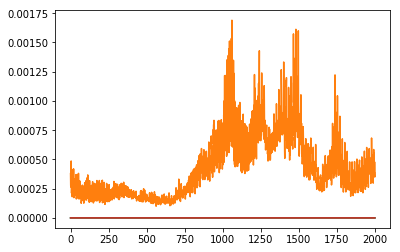

In [33]:
m=20
plt.plot(waves_c[0][m].squeeze().data.cpu().numpy()[8000:10000])
plt.plot(history[0][:,m,1].cpu().data.numpy()[8000:10000])
plt.plot(history[1][:,m,1].cpu().data.numpy()[8000:10000])
plt.plot(history[2][:,m,1].cpu().data.numpy()[8000:10000])

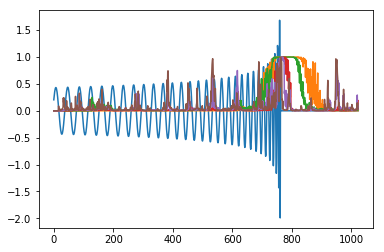

In [34]:
m=28
plt.plot(waves_c[2][m].squeeze().data.cpu().numpy())
plt.plot(history[3][:,m,1].cpu().data.numpy())
plt.plot(history[4][:,m,1].cpu().data.numpy())
plt.plot(history[5][:,m,1].cpu().data.numpy())
plt.plot(history[6][:,m,1].cpu().data.numpy())
plt.plot(history[7][:,m,1].cpu().data.numpy())

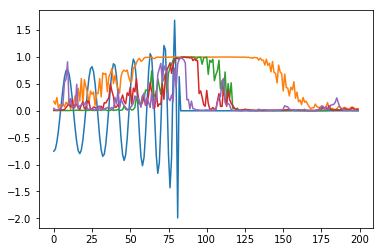

In [38]:
st=680
interval=200
plt.plot(waves_c[2][m].squeeze().data.cpu().numpy()[st:st+interval])
#plt.plot(history[3][:,m,1].cpu().data.numpy()[st:st+interval])
plt.plot(history[4][:,m,1].cpu().data.numpy()[st:st+interval])
plt.plot(history[5][:,m,1].cpu().data.numpy()[st:st+interval])
plt.plot(history[6][:,m,1].cpu().data.numpy()[st:st+interval])
plt.plot(history[7][:,m,1].cpu().data.numpy()[st:st+interval])

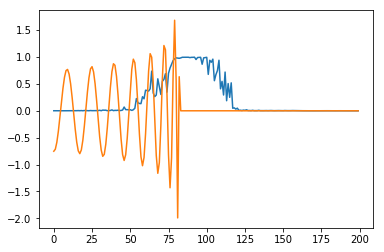

In [39]:
history_sum=history[4]*history[5]
plt.plot(history_sum[:,m,1].cpu().data.numpy()[st:st+interval])
plt.plot(waves_c[2][m].squeeze().data.cpu().numpy()[st:st+interval])

In [42]:
batch_size=100
step=12
waves,waves_c,tc=get_batch(batch_size,step,noise_factor=1.0,train_id=16)
resolution=[2048,1024,512,256,128,64,32,16]
zoom=[16384,1024]
history=[[],[],[],[],[],[],[],[]]
history[0]=torch.zeros(zoom[0],batch_size*3,2)
history[1]=torch.zeros(zoom[0],batch_size*3,2)
history[2]=torch.zeros(zoom[0],batch_size*3,2)

with torch.no_grad():
    for i in range(zoom[0]-resolution[1]):
        out_cut=net_1024(waves[0][:,:,i:i+resolution[1],:])
        history[1][i+resolution[1],:,:]=out_cut.squeeze()
    for i in range(zoom[0]-resolution[2]):
        out_cut=net_512(waves[0][:,:,i:i+resolution[2],:])
        history[2][i+resolution[2],:,:]=out_cut.squeeze()
history_plus1=history[1]*history[2]


'\nwith torch.no_grad():\n    for i in range(zoom[0]-resolution[1]):\n        out_cut=net_1024(waves[0][:,:,i:i+resolution[1],:])\n        history[1][i+resolution[1],:,:]=out_cut.squeeze()\n    for i in range(zoom[0]-resolution[2]):\n        out_cut=net_512(waves[0][:,:,i:i+resolution[2],:])\n        history[2][i+resolution[2],:,:]=out_cut.squeeze()\nhistory_plus1=history[1]*history[2]\n'

In [17]:
pred0=history_plus1[:,:,1].squeeze().max(0)[1].cpu().numpy()
start_p=pred0-600
wave_zoom1=torch.zeros(3*batch_size,1,resolution[1],1).double().to(device)
wavec_zoom1=torch.zeros(3*batch_size,1,resolution[1],1).double().to(device)
for i in range(3*batch_size):
    wave_zoom1[i,:,:,:]=waves[0][i,:,start_p[i]:start_p[i]+resolution[1],:]
    wavec_zoom1[i,:,:,:]=waves_c[0][i,:,start_p[i]:start_p[i]+resolution[1],:]

history[3]=torch.zeros(zoom[1],batch_size*3,2)
history[4]=torch.zeros(zoom[1],batch_size*3,2)
history[5]=torch.zeros(zoom[1],batch_size*3,2)
history[6]=torch.zeros(zoom[1],batch_size*3,2)
history[7]=torch.zeros(zoom[1],batch_size*3,2)
with torch.no_grad():
    for i in range(zoom[1]-resolution[3]):
        out_cut=net_256(wave_zoom1[:,:,i:i+resolution[3],:])
        history[3][i+resolution[3],:,:]=out_cut.squeeze()
    for i in range(zoom[1]-resolution[4]):
        out_cut=net_128(wave_zoom1[:,:,i:i+resolution[4],:])
        history[4][i+resolution[4],:,:]=out_cut.squeeze()
    for i in range(zoom[1]-resolution[5]):
        out_cut=net_64(wave_zoom1[:,:,i:i+resolution[5],:])
        history[5][i+resolution[5],:,:]=out_cut.squeeze()
    for i in range(zoom[1]-resolution[6]):
        out_cut=net_32(wave_zoom1[:,:,i:i+resolution[6],:])
        history[6][i+resolution[6],:,:]=out_cut.squeeze()
    for i in range(zoom[1]-resolution[7]):
        out_cut=net_16(wave_zoom1[:,:,i:i+resolution[7],:])
        history[7][i+resolution[7],:,:]=out_cut.squeeze()

    

/home/ymh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ymh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Text(0.5,0,'time step')

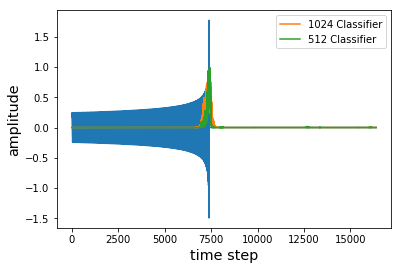

In [18]:
m=8
plt.plot(waves_c[0][m].squeeze().data.cpu().numpy())
#plt.plot(history[0][:,m,1].cpu().data.numpy()[8000:10000])
plt.plot(history[1][:,m,1].cpu().data.numpy(),label='1024 Classifier')
plt.plot(history[2][:,m,1].cpu().data.numpy(),label='512 Classifier')
plt.legend()
#plt.title('16384 step',fontsize='x-large')
plt.ylabel('amplitude',fontsize='x-large')
plt.xlabel('time step',fontsize='x-large')

Text(0.5,0,'time step')

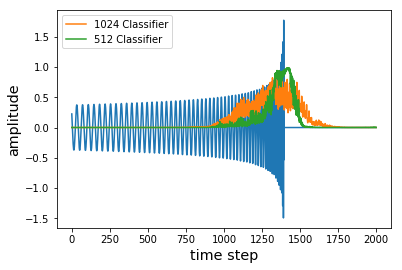

In [19]:
m=8
plt.plot(waves_c[0][m].squeeze().data.cpu().numpy()[6000:8000])
#plt.plot(history[0][:,m,1].cpu().data.numpy()[8000:10000])
plt.plot(history[1][:,m,1].cpu().data.numpy()[6000:8000],label='1024 Classifier')
plt.plot(history[2][:,m,1].cpu().data.numpy()[6000:8000],label='512 Classifier')
plt.legend()
plt.ylabel('amplitude',fontsize='x-large')
plt.xlabel('time step',fontsize='x-large')

Text(0.5,0,'time step')

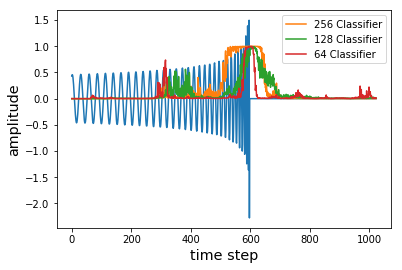

In [20]:
m=9
plt.plot(wavec_zoom1[m,:,:,:].squeeze().data.cpu().numpy())
plt.plot(history[3][:,m,1].cpu().data.numpy(),label='256 Classifier')
plt.plot(history[4][:,m,1].cpu().data.numpy(),label='128 Classifier')
plt.plot(history[5][:,m,1].cpu().data.numpy(),label='64 Classifier')
#plt.plot(history[6][:,m,1].cpu().data.numpy())
#plt.plot(history[7][:,m,1].cpu().data.numpy())
history_plus2=history[4]*history[5]*history[6]*history[7]
pred1=history_plus2
plt.legend()
plt.ylabel('amplitude',fontsize='x-large')
plt.xlabel('time step',fontsize='x-large')

Text(0.5,0,'time step')

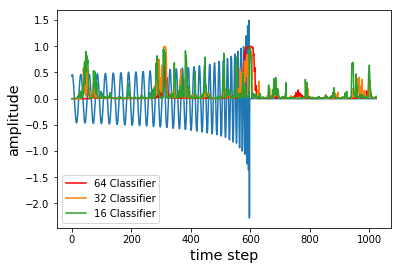

In [21]:
plt.plot(wavec_zoom1[m,:,:,:].squeeze().data.cpu().numpy())
#plt.plot(history[3][:,m,1].cpu().data.numpy())
#plt.plot(history[4][:,m,1].cpu().data.numpy())
plt.plot(history[5][:,m,1].cpu().data.numpy(),'r',label='64 Classifier')
plt.plot(history[6][:,m,1].cpu().data.numpy(),label='32 Classifier')
plt.plot(history[7][:,m,1].cpu().data.numpy(),label='16 Classifier')
history_plus2=history[4]*history[5]*history[6]*history[7]
plt.legend()
plt.ylabel('amplitude',fontsize='x-large')
plt.xlabel('time step',fontsize='x-large')

Text(0.5,0,'time step')

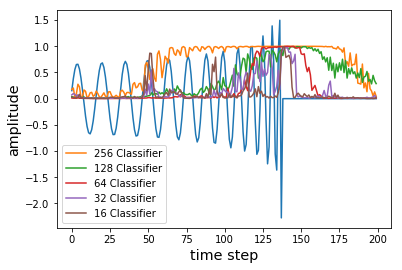

In [22]:
st=460
interval=200
plt.plot(wavec_zoom1[m,:,:,:].squeeze().data.cpu().numpy()[st:st+interval])
plt.plot(history[3][:,m,1].cpu().data.numpy()[st:st+interval],label='256 Classifier')
plt.plot(history[4][:,m,1].cpu().data.numpy()[st:st+interval],label='128 Classifier')
plt.plot(history[5][:,m,1].cpu().data.numpy()[st:st+interval],label='64 Classifier')
plt.plot(history[6][:,m,1].cpu().data.numpy()[st:st+interval],label='32 Classifier')
plt.plot(history[7][:,m,1].cpu().data.numpy()[st:st+interval],label='16 Classifier')
plt.legend()
plt.ylabel('amplitude',fontsize='x-large')
plt.xlabel('time step',fontsize='x-large')

Text(0.5,0,'time step')

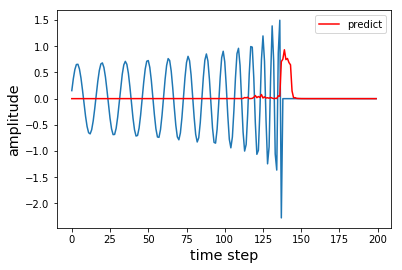

In [23]:
plt.plot(wavec_zoom1[m,:,:,:].squeeze().data.cpu().numpy()[st:st+interval])
plt.plot(history_plus2[:,m,1].cpu().data.numpy()[st:st+interval],'r',label='predict')
plt.legend()
plt.ylabel('amplitude',fontsize='x-large')
plt.xlabel('time step',fontsize='x-large')

In [42]:
a=(history_plus2[:,:,1].max(0)[1].cpu().data.numpy()+start_p)/16384-tc.cpu().numpy()


In [80]:
error=0
for i in range(3*batch_size):
    if abs(a[i])>5e-3:
        error=error+1
        print(i)
error

76
82
124
257
286


5

In [40]:
def omega_calculate(pred):
    V1=np.array([-2.161414928e6, -3.834695183e6, 4.600350224e6]).reshape(1,3)
    V2=np.array([-7.427604192e4 ,  -5.496283721e6 , 3.224257016e6]).reshape(1,3)
    V3=np.array([4.546374e6 , 0.842990e6 , 4.378577e6]).reshape(1,3)
    V=np.concatenate((V1-V2,V2-V3,V3-V1),0)
    delay_sub=np.array([pred[0]-pred[1],pred[1]-pred[2],pred[2]-pred[0]])
    #print('delay:',delay_sub)
    weight0=-c*delay_sub[0]/np.linalg.norm(V[0,:],2)
    weight1=-c*delay_sub[1]/np.linalg.norm(V[1,:],2)
    weight2=-c*delay_sub[2]/np.linalg.norm(V[2,:],2)
    print('weight:',weight0,weight1,weight2)
    V[0,:]=V[0,:]/np.linalg.norm(V[0,:],2)
    V[1,:]=V[1,:]/np.linalg.norm(V[1,:],2)
    V[2,:]=V[2,:]/np.linalg.norm(V[2,:],2)
    
    V01_cross=np.cross(V[0,:],V[1,:])
    V01_cross=V01_cross/np.linalg.norm(V01_cross,2)
    
    
    V_beta0=V[0,:]
    V_beta1=V[1,:]-np.dot(V[1,:],V[0,:])*V[0,:]/np.dot(V[0,:],V[0,:])
    weight_beta0=weight0
    weight_beta1=weight1-np.dot(V[1,:],V[0,:])*weight0/np.dot(V[0,:],V[0,:])
    weight_beta1=weight_beta1/np.linalg.norm(V_beta1,2)
    V_beta1=V_beta1/np.linalg.norm(V_beta1,2)
        
    V01_flat=weight_beta0*V_beta0+weight_beta1*V_beta1
    print('weight_beta:',weight_beta0,weight_beta1,weight_beta0**2+weight_beta1**2,np.dot(V01_flat,V01_flat))
    weight_cross=np.sqrt(1-np.dot(V01_flat,V01_flat))
    if np.dot(V01_flat,V01_flat)>1.0 and np.dot(V01_flat,V01_flat)<1.1:
        weight_cross=0
    Omega1=V01_flat+weight_cross*V01_cross
    Omega2=V01_flat-weight_cross*V01_cross
    
    return Omega1,Omega2
def omega_real(param):
    stheta=param[4]
    sphi=param[3]
    Omega_real=math.sin(stheta)*math.cos(sphi),math.sin(stheta)*math.sin(sphi),math.cos(stheta)
    return Omega_real

In [41]:
pred_tc=(history_plus2[:,:,1].max(0)[1].cpu().data.numpy()+start_p)/16384
params=get_params(batch_size,step)
count=[]
error1=[]
for i in range(batch_size):
    pred=pred_tc[3*i:3*i+3]
    omega1,omega2=omega_calculate(pred)
    if math.isnan(omega1[0]):
        count.append(i)
    Omega_real=omega_real(params[i])
    distance1=np.linalg.norm((omega1-Omega_real),2)
    error1.append(distance1)
    print(i,omega1,omega2)
    print(Omega_real)
print(count)

NameError: name 'history_plus2' is not defined

In [27]:
analyse_out1=analyse_1024to64(wave_zoom1)
analyse_pred1=analyse_out1.max(1)[1].cpu().numpy()*1024/64
analyse_start=np.int32(analyse_pred1-30)
analyse_zoom2=torch.zeros(3*batch_size,1,resolution[4],1).double().to(device)
analysec_zoom2=torch.zeros(3*batch_size,1,resolution[4],1).double().to(device)
for i in range(3*batch_size):
    analyse_zoom2[i,:,:,:]=wave_zoom1[i,:,analyse_start[i]:analyse_start[i]+resolution[4],:]
    analysec_zoom2[i,:,:,:]=wavec_zoom1[i,:,analyse_start[i]:analyse_start[i]+resolution[4],:]
analyse_out2=analyse_128to32(analyse_zoom2)
analyse_pred2=analyse_out2.max(1)[1].cpu().numpy()*128/32

/home/ymh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ymh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [35]:
analyse_pred_tc=(analyse_pred2+analyse_start+start_p)/16384
params=get_params(batch_size,step)
count=[]
error2=[]
for i in range(batch_size):
    pred=analyse_pred_tc[3*i:3*i+3]
    omega1,omega2=omega_calculate(pred)
    if math.isnan(omega1[0]):
        count.append(i)
    Omega_real=omega_real(params[i])
    distance2=np.linalg.norm((omega1-Omega_real),2)
    error2.append(distance2)
    print(i,omega1,omega2)
    print(Omega_real)
print(count)

weight: -0.21334897546378767 -0.4500038462646883 0.5144421027013734
weight_beta: -0.21334897546378767 -0.47479400892813445 0.27094713624549727 0.2709471362454973
0 [ 0.70656855 -0.08018378  0.70308709] [ 0.21562263  0.55231916 -0.8052642 ]
(0.7055750221080489, -0.09908282329239938, 0.701674057027644)
weight: 0.5973771312986055 -0.35769536497962406 0.12749217327816645
weight_beta: 0.5973771312986055 -0.29712077355784833 0.4451401910781655 0.4451401910781654
1 [-0.0054905   0.2764055   0.96102542] [-0.43378823  0.82819658 -0.35484954]
(-0.0041376163167619615, 0.27153183311300355, 0.9624205648974399)
weight: 0.23773171551679198 -0.30231027620858547 0.20577684108054936
weight_beta: 0.23773171551679198 -0.279077967488037 0.13440088049981075 0.13440088049981072
2 [ 0.28601214 -0.00483102  0.95821382] [-0.24893706  0.68436291 -0.68533039]
(0.24999720755787794, -0.027632746383545546, 0.967852172359274)
weight: 0.36574110079506456 0.18230925053800193 -0.31090196641517787
weight_beta: 0.36574110

/home/ymh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


In [36]:
error2

[0.0189778143560915,
 0.005246844687718397,
 0.04370231194402431,
 0.027626966227182855,
 0.031381731718768936,
 0.00437961141291619,
 0.012637739671164128,
 0.008545848651574255,
 0.005204399924738903,
 0.013289696992698866,
 0.009273206986643823,
 0.11488385006360785,
 0.00629290546841078,
 0.017581858406218284,
 0.3903284604446224,
 0.00576980818018887,
 0.4545304658422322,
 0.08383170956643828,
 0.14988117069381063,
 0.015150128568055116,
 0.2912538496314742,
 0.022233421061864336,
 0.008408590384813418,
 0.018459055038973934,
 0.008687989118217864,
 0.023581149664193342,
 0.005508772937695347,
 0.08492284839100962,
 0.1095545718821226,
 0.049672038612015045,
 0.010766426534351992,
 0.13985257258427863,
 0.040937353006132896,
 0.01032837629116191,
 0.01652260661188358,
 0.007914249943372233,
 0.03591025806858996,
 0.005480923847705461,
 0.0065221829676821875,
 0.050967809988896585,
 0.00453421550286401,
 0.019928894397101105,
 0.004879071797432732,
 0.005821119781897287,
 0.0486340

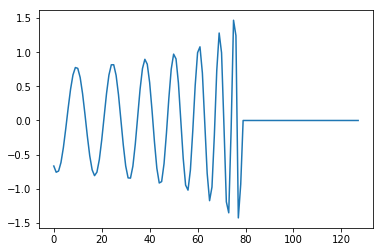

In [288]:
plt.plot(analysec_zoom2[m,0,:,0].data.cpu().numpy())

Text(0.5,0,'wave ID')

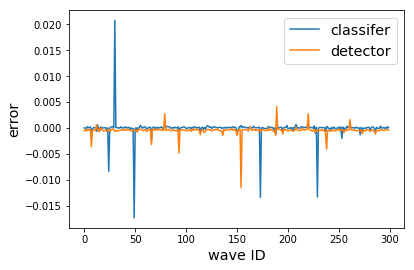

In [292]:
plt.plot(a,label='classifer')
plt.plot(analyse_pred_tc-tc.data.cpu().numpy(),label='detector')
plt.legend(fontsize='x-large')
plt.ylabel('error',fontsize='x-large')
plt.xlabel('wave ID',fontsize='x-large')

In [289]:
rem_a=[]
rem_c=[]
for i in range(3*batch_size):
    if abs(analyse_pred_tc[i]-tc.data.cpu().numpy()[i])>0.002:
        rem_a.append(i)
    if abs(pred_tc[i]-tc.data.cpu().numpy()[i])>0.002:
        rem_c.append(i)

In [290]:
rem_a

[7, 66, 79, 93, 154, 189, 220, 238]

In [291]:
rem_c

[24, 30, 49, 66, 173, 229, 253]

In [ ]:
m=238

plt.plot(analyse_out2[m,:].data.cpu().numpy())